In [1]:
%matplotlib inline
import glob
import logging
import os
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.transforms import (
    AddChannel, Compose, LoadImage, 
    ScaleIntensity, ToTensor, NormalizeIntensity, HistogramNormalize, ResizeWithPadOrCrop
)
from monai.data import write_nifti

import ignite
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colorbar
# import scipy.ndimage

print_config()

MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 7.0.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.1+cu102
tqdm version: 4.61.0
lmdb version: 1.2.1
psutil version: 5.5.1
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from typing import Any, Optional, Sequence, Tuple, Union
from monai.utils import ensure_tuple_rep
from monai.networks.nets import UNet
from monai.networks.blocks import Convolution, ResidualUnit, SubpixelUpsample
from monai.networks.layers import Act, Conv, Norm
from monai.networks.layers.simplelayers import SkipConnection
from monai.networks.layers.convutils import same_padding

# define Shuffle UNet
class ShuffleUNet(UNet):
    def __init__(
        self,
        dimensions: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act: Union[Tuple, str] = Act.PRELU,
        norm: Union[Tuple, str] = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
    ) -> None:
                
        super().__init__(
            dimensions,
            in_channels,
            out_channels,
            channels,
            strides,
        )

        def _create_block(
            inc: int, outc: int, channels: Sequence[int], strides: Sequence[int], is_top: bool
        ) -> nn.Sequential:
            """
            Builds the UNet structure from the bottom up by recursing down to the bottom block, then creating sequential
            blocks containing the downsample path, a skip connection around the previous block, and the upsample path.
            Args:
                inc: number of input channels.
                outc: number of output channels.
                channels: sequence of channels. Top block first.
                strides: convolution stride.
                is_top: True if this is the top block.
            """
            c = channels[0]
            s = strides[0]

            subblock: nn.Module

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], False)  # continue recursion down
                upc = c * 2
            else:
                # the next layer is the bottom so stop recursion, create the bottom layer as the sublock for this layer
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            down = self._get_down_layer(inc, c, s, is_top)  # create layer in downsampling path
            up = self._get_up_layer(upc, outc, s, is_top)  # create layer in upsampling path

            return nn.Sequential(down, SkipConnection(subblock), up)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, True)

                                   
    def _get_up_layer(self, in_channels: int, out_channels: int, strides: int, is_top: bool) -> nn.Module:
        
        """
        Args:
            in_channels: number of input channels.
            out_channels: number of output channels.
            strides: convolution stride.
            is_top: True if this is the top block.
        """
        decode = nn.Sequential()
        shuffle = SubpixelUpsample(self.dimensions, in_channels, out_channels, strides)
        
        conv = Convolution(
            self.dimensions,
            out_channels,
            out_channels,
            strides=1,
            kernel_size=self.up_kernel_size,
            act=self.act,
            norm=self.norm,
            dropout=self.dropout,
            conv_only=is_top and self.num_res_units == 0,
            is_transposed=True,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions,
                out_channels,
                out_channels,
                strides=1,
                kernel_size=self.kernel_size,
                subunits=1,
                act=self.act,
                norm=self.norm,
                dropout=self.dropout,
                bias=self.bias,
                last_conv_only=is_top,
            )
            conv = nn.Sequential(conv, ru)
        
        decode.add_module('shuffle', shuffle)
        decode.add_module('conv',conv)        

        return decode

In [4]:
# set network parameters and check net shape
net = ShuffleUNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size = 3,
    up_kernel_size = 3,
    num_res_units=2
)

n = torch.rand(1, 1, 256, 256, 32)

print(net(n).shape)  # should be [1, 1, 256, 256, 32]

torch.Size([1, 1, 256, 256, 32])


In [5]:
# define patch-based inference function
# patches are 256 x 256 x 32 (i.e. 32 slices in axial/transverse plane)
def do_inference_3D(net, x, dims=(256,256), patch_size=(256,256,32), step_size=2): 
    # pad image
    y = np.ones_like(x)
    pad_val = x[5,5,5] # find background value
    y *= 0
    in_shape = x.shape[0:2]
    z_size = patch_size[2]
    pad_dims = tuple(((d1-d2)//2, (d1-d2)-(d1-d2)//2) for d1,d2 in zip(dims,in_shape))
    pad_dims = pad_dims + ((0,z_size*2),)
    x_pad = np.pad(x, pad_dims, 'constant', constant_values=pad_val)
    y_pad = np.pad(y, pad_dims, 'constant', constant_values=0)
    
    num_overlaps = np.zeros(y_pad.shape)
    
    xptrans = Compose(
        [
            AddChannel(),
            AddChannel(),
            ToTensor(),
        ]
    )
    
    # iterate through patches & infer
    zz = 0
    while zz + z_size < x_pad.shape[2]:
        xp = x_pad[:,:,zz:zz+z_size]
        txp = xptrans(xp).to(device)
        output = net(txp)
        output = output[0,0,...].cpu().data.numpy()
        y_pad[:,:,zz:zz+z_size] += output
        num_overlaps[:,:,zz:zz+z_size] +=1
        zz += step_size            
            
    y = y_pad[pad_dims[0][0]:y_pad.shape[0]-pad_dims[0][1], 
              pad_dims[1][0]:y_pad.shape[1]-pad_dims[1][1], 
              pad_dims[2][0]:y_pad.shape[2]-pad_dims[2][1]]
    num_overlaps = num_overlaps[pad_dims[0][0]:y_pad.shape[0]-pad_dims[0][1], 
                                pad_dims[1][0]:y_pad.shape[1]-pad_dims[1][1], 
                                pad_dims[2][0]:y_pad.shape[2]-pad_dims[2][1]]
    y=y/num_overlaps
    
    return y

In [6]:
import copy 
# set input and output data
input_mr_file = '/home/Researcher/Analysis/mr-to-pct_tests/sub-test01_t1w.nii'
output_pct_file = '/home/Researcher/Analysis/mr-to-pct_tests/sub-test01_pct.nii'

# trained model to load
saved_model = torch.load("/home/Researcher/Analysis/mr-to-pct_tests/pretrained_net_final_20220825.pth")

spatial_size = [256,256,256]
t1trans_test = Compose(
    [
        # NormalizeIntensity(),
        HistogramNormalize(num_bins=256, min=0, max=255),
        ScaleIntensity(minv=-1.0, maxv=1.0),
        AddChannel(),
        ResizeWithPadOrCrop(spatial_size, mode='minimum'),
    ]
)

# load MRIs
print('Running MR to pCT for {}'.format(input_mr_file))
t1_arr, t1_meta = LoadImage()(input_mr_file)
orig_t1_arr = copy.copy(t1_arr)
t1_arr = t1trans_test(t1_arr)
t1_arr = t1_arr[0]

net.to(device)
net.load_state_dict(saved_model)
net.cuda()
net.eval()

with torch.no_grad():
    ct_out = do_inference_3D(net, t1_arr)
    
ct_out = ResizeWithPadOrCrop(t1_meta['spatial_shape'], mode='minimum')(AddChannel()(ct_out))
write_nifti(ct_out[0], (output_pct_file), affine=t1_meta['affine'])
torch.cuda.empty_cache()


Running MR to pCT for /home/Researcher/Analysis/mr-to-pct_tests/sub-test01_t1w.nii


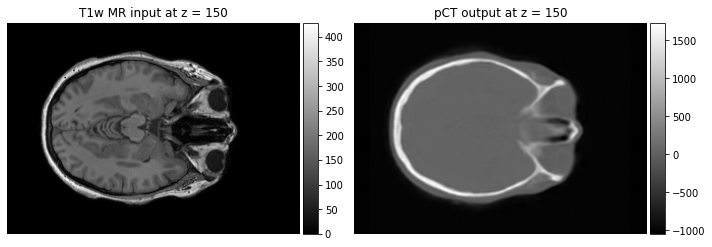

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot an example slice at z = 150
z = 150

fig = plt.figure(figsize=(10,10))

# plot input MR
ax1 = fig.add_subplot(1,2,1)
im1 = ax1.imshow(orig_t1_arr[:,:,z], cmap='gray')
ax1.set_title('T1w MR input at z = {}'.format(z))
ax1.axis('off')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

# plot output pCT
ax2 = fig.add_subplot(1,2,2)
im2 = ax2.imshow(ct_out[0,:,:,z], cmap='gray')
ax2.set_title('pCT output at z = {}'.format(z))
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.tight_layout()
